In [1]:
!pip install fastai librosa --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.0 MB/s eta 0:00:00


In [2]:
from fastai.vision.all import *
import librosa
import numpy as np
import sys

# -------- Audio Preprocessing -------- #
def load_and_preprocess_audio(file_path, sr=22050, duration=3):
    try:
        y, sr = librosa.load(file_path, sr=sr, duration=duration)
        if len(y) < sr * duration:
            y = np.pad(y, (0, sr * duration - len(y)))
        mel_spect = librosa.feature.melspectrogram(
            y=y, sr=sr, n_mels=128, fmax=8000
        )
        mel_spect_db = librosa.power_to_db(mel_spect, ref=np.max)
        return mel_spect_db
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

# -------- Prediction Function -------- #
def predict_audio(audio_path, model_path='audio_classifier.pkl'):
    # Load model
    learn = load_learner(model_path)

    # Preprocess audio
    mel_spect = load_and_preprocess_audio(audio_path)
    if mel_spect is None:
        return {"error": "Failed to preprocess audio"}

    # Convert spectrogram to 3-channel image
    mel_spect = (mel_spect - mel_spect.min()) / (mel_spect.max() - mel_spect.min())
    mel_spect_3d = np.repeat(mel_spect[..., None], 3, axis=-1)
    mel_spect_uint8 = (mel_spect_3d * 255).astype(np.uint8)

    # Predict
    pred_class, pred_idx, probs = learn.predict(mel_spect_uint8)
    return {
        "predicted_class": str(pred_class),
        "confidence": float(probs[pred_idx])
    }



In [3]:
# Re-declare the same functions used during training

def load_and_preprocess_audio(file_path, sr=22050, duration=3):
    try:
        y, sr = librosa.load(file_path, sr=sr, duration=duration)
        if len(y) < sr * duration:
            y = np.pad(y, (0, sr * duration - len(y)))
        mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
        mel_spect_db = librosa.power_to_db(mel_spect, ref=np.max)
        return mel_spect_db
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

def get_x(row):
    mel_spect = load_and_preprocess_audio(row.fname)
    if mel_spect is None or mel_spect.size == 0:
        print(f"Failed to process {row.fname}")
        return np.zeros((128, 128, 3), dtype=np.uint8)
    mel_spect = (mel_spect - mel_spect.min()) / (mel_spect.max() - mel_spect.min())
    mel_spect_3d = np.repeat(mel_spect[..., None], 3, axis=-1)
    mel_spect_uint8 = (mel_spect_3d * 255).astype(np.uint8)
    return mel_spect_uint8
def get_y(file_path):
    # Example: extract label from parent folder name
    return file_path.parent.name


In [4]:
from fastai.vision.all import PILImage
from PIL import Image

def predict_audio(audio_path, model_path='audio_classifier.pkl'):
    # Load model
    learn = load_learner(model_path)

    # Preprocess audio
    mel_spect = load_and_preprocess_audio(audio_path)
    if mel_spect is None:
        return {"error": "Failed to preprocess audio"}

    # Normalize and convert to 3-channel uint8
    mel_spect = (mel_spect - mel_spect.min()) / (mel_spect.max() - mel_spect.min())
    mel_spect_3d = np.repeat(mel_spect[..., None], 3, axis=-1)
    mel_spect_uint8 = (mel_spect_3d * 255).astype(np.uint8)

    # Convert to PIL image (which is what fastai expects)
    pil_img = PILImage.create(Image.fromarray(mel_spect_uint8))

    # Predict
    pred_class, pred_idx, probs = learn.predict(pil_img)

    return {
        "predicted_class": str(pred_class),
        "confidence": float(probs[pred_idx])
    }


In [12]:
# Example: set the path to your .wav file stored in Google Drive or local Colab path
audio_path = "/content/7383-3-0-1.wav"

# Call the function and print result
result = predict_audio(audio_path)
print("Prediction:", result)


/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


Prediction: {'predicted_class': '3', 'confidence': 0.9998420476913452}


In [8]:
pip install captum --upgrade


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 113.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [9]:
pip install numpy==1.26.4


In [10]:
pip install matplotlib


In [11]:
!pip install captum matplotlib
!pip install numpy==1.26.4


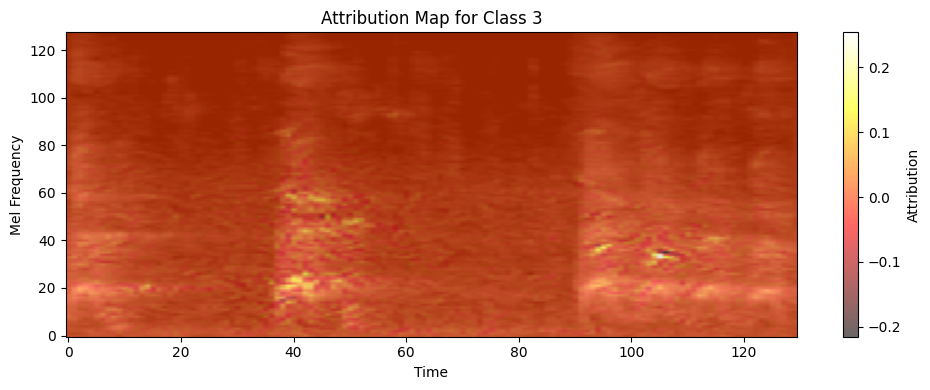

Prediction: {'predicted_class': '3', 'confidence': 0.9927958846092224}


In [13]:
from fastai.vision.all import *
import librosa
import numpy as np
from PIL import Image
import torch
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt

def load_and_preprocess_audio(file_path, sr=22050, duration=3):
    try:
        y, sr = librosa.load(file_path, sr=sr, duration=duration)
        if len(y) < sr * duration:
            y = np.pad(y, (0, sr * duration - len(y)))
        mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
        mel_spect_db = librosa.power_to_db(mel_spect, ref=np.max)
        return mel_spect_db
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

def predict_with_xai(audio_path, model_path='audio_classifier.pkl'):
    # Load model
    learn = load_learner(model_path)
    model = learn.model.eval()

    # Preprocess audio
    mel_spect = load_and_preprocess_audio(audio_path)
    if mel_spect is None:
        return {"error": "Failed to preprocess audio"}

    # Normalize and convert to 3-channel
    mel_spect = (mel_spect - mel_spect.min()) / (mel_spect.max() - mel_spect.min())
    mel_spect_3d = np.repeat(mel_spect[..., None], 3, axis=-1)
    mel_tensor = torch.tensor(mel_spect_3d).permute(2, 0, 1).unsqueeze(0).float()

    # Move to model's device
    device = next(model.parameters()).device
    mel_tensor = mel_tensor.to(device)

    # Get prediction
    with torch.no_grad():
        output = model(mel_tensor)
        pred_idx = output.argmax(dim=1).item()

    # Attribution with Integrated Gradients
    ig = IntegratedGradients(model)
    attr, _ = ig.attribute(mel_tensor, target=pred_idx, return_convergence_delta=True)

    # Visualize attribution (convert to numpy)
    attr_np = attr.squeeze().cpu().numpy().mean(axis=0)

    # Plot attribution over spectrogram
    plt.figure(figsize=(10, 4))
    plt.imshow(mel_spect, aspect='auto', origin='lower', cmap='gray')
    plt.imshow(attr_np, cmap='hot', alpha=0.6, aspect='auto', origin='lower')
    plt.colorbar(label='Attribution')
    plt.title(f'Attribution Map for Class {learn.dls.vocab[pred_idx]}')
    plt.xlabel("Time")
    plt.ylabel("Mel Frequency")
    plt.tight_layout()
    plt.show()

    return {
        "predicted_class": str(learn.dls.vocab[pred_idx]),
        "confidence": float(torch.nn.functional.softmax(output, dim=1)[0][pred_idx])
    }

# Example usage
audio_path = "/content/7383-3-0-1.wav"
result = predict_with_xai(audio_path)
print("Prediction:", result)


In [28]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import LayerGradCam

def grad_cam_visualization(model, mel_tensor, target_class):
    # Use a LayerGradCam instance to compute the Grad-CAM at the output layer
    grad_cam = LayerGradCam(model, model[0][0])  # Assuming the model has a CNN structure
    attribution = grad_cam.attribute(mel_tensor, target=target_class)

    # Convert the attribution to a numpy array and normalize
    attribution = attribution.squeeze().cpu().detach().numpy()
    attribution -= attribution.min()
    attribution /= attribution.max()

    return attribution

def visualize_grad_cam(mel_spect, attribution):
    # Plot the Grad-CAM attribution
    plt.figure(figsize=(10, 4))
    plt.imshow(mel_spect, aspect='auto', origin='lower', cmap='gray')
    plt.imshow(attribution, cmap='hot', alpha=0.6, aspect='auto', origin='lower')
    plt.colorbar(label='Attribution')
    plt.title("Grad-CAM Attribution Map")
    plt.xlabel("Time")
    plt.ylabel("Mel Frequency")
    plt.tight_layout()
    plt.show()

# Example usage in the prediction pipeline:
def predict_with_grad_cam(audio_path, model_path='audio_classifier.pkl'):
    # Load model
    learn = load_learner(model_path)
    model = learn.model.eval()

    # Preprocess audio
    mel_spect = load_and_preprocess_audio(audio_path)
    if mel_spect is None:
        return {"error": "Failed to preprocess audio"}

    # Normalize and convert to 3-channel
    mel_spect = (mel_spect - mel_spect.min()) / (mel_spect.max() - mel_spect.min())
    mel_spect_3d = np.repeat(mel_spect[..., None], 3, axis=-1)
    mel_tensor = torch.tensor(mel_spect_3d).permute(2, 0, 1).unsqueeze(0).float()

    # Move to model's device
    device = next(model.parameters()).device
    mel_tensor = mel_tensor.to(device)

    # Get prediction
    with torch.no_grad():
        output = model(mel_tensor)
        pred_idx = output.argmax(dim=1).item()

    # Grad-CAM Visualization
    attribution = grad_cam_visualization(model, mel_tensor, target_class=pred_idx)

    # Plot attribution
    visualize_grad_cam(mel_spect, attribution)

    return {
        "predicted_class": str(learn.dls.vocab[pred_idx]),
        "confidence": float(torch.nn.functional.softmax(output, dim=1)[0][pred_idx])
    }


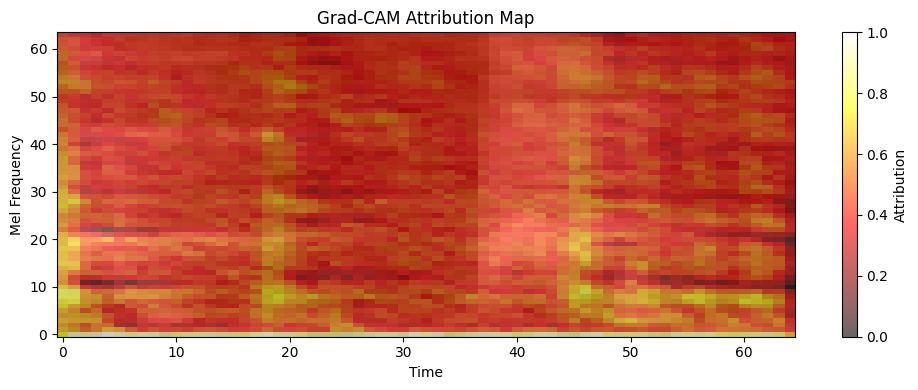

Prediction: {'predicted_class': '3', 'confidence': 0.9927958846092224}


In [24]:
from IPython.display import Audio

# Example usage
audio_path = "/content/7383-3-0-1.wav"
result = predict_with_grad_cam(audio_path)
print("Prediction:", result)

# Play the audio file in Colab
Audio(audio_path)


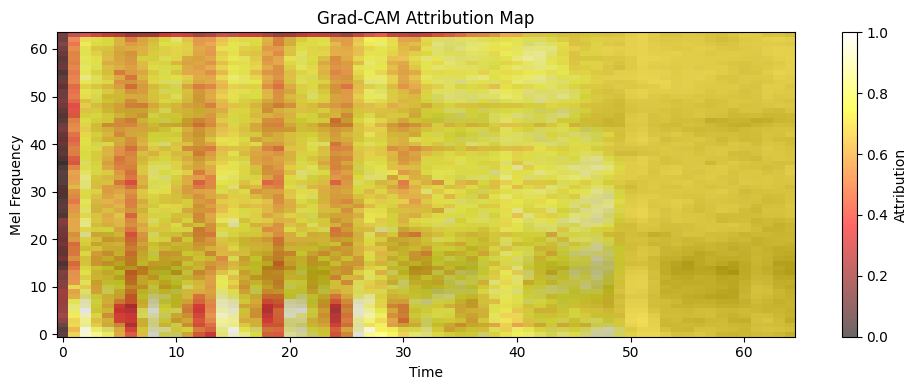

Prediction: {'predicted_class': '6', 'confidence': 0.9919663667678833}


In [25]:
# Example usage
audio_path = "/content/7061-6-0-0.wav"
result = predict_with_grad_cam(audio_path)
print("Prediction:", result)
Audio(audio_path)

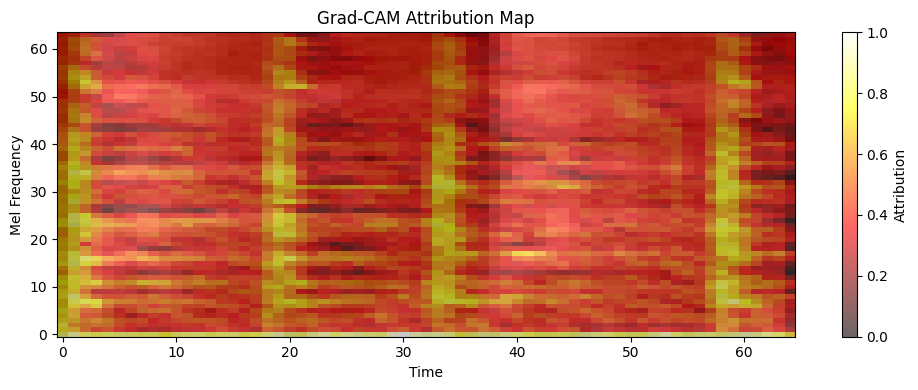

Prediction: {'predicted_class': '3', 'confidence': 0.9914906620979309}


In [27]:
# Example usage
audio_path = "/content/7383-3-1-0.wav"
result = predict_with_grad_cam(audio_path)
print("Prediction:", result)
Audio(audio_path)